<font size="3">**Tarea 1 2025**</font>

<u> *Instrucciones* </u>

Su notebook con las respuestas a la tarea se deben entregar a mas tardar el dia 21/04/25 hasta las 21:00, subiendolo al repositorio en la carpeta tareas/2025. 

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es **machine_failure_data.csv**.

Las variables tienen la siguiente descripcion:

- Date: data medida en frecuencia diaria
- Location: ubicacion del medidor
- Min_Temp: temperatura minima observada
- Max_Temp: temperatura maxima observada
- Leakage: Filtracion medida en el area
- Evaporation: Tasa de evaporacion
- Electricity: Consumo electrico KW
- Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
- Failure today: El sensor reporta fallo (o no)

1. Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
from scipy.stats import nbinom
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# Puntitos para salir de carpeta. Primero abrimos el archivo.
df = pd.read_csv('../../data/machine_failure_data.csv')
df.reset_index(drop=True, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

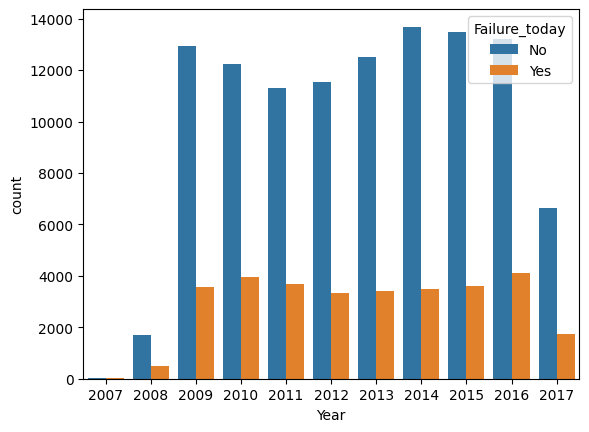

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year

sns.countplot(data=df, x='Year', hue='Failure_today')

df['Month'] = df['Date'].dt.month


Este gráfico muestra la cantidad de datos por año, el color naranjo reprensenta los datos sobre los fallos. Se puede observar que el 2007 hay una cantidad de datos significativamente menor comparado a la cantidad de datos en los demás años.

Ahora vamos a estandarizar con método común y logarítmico y vamos a ver  cuál es mejor.

<Axes: xlabel='Log_Leakage', ylabel='Density'>

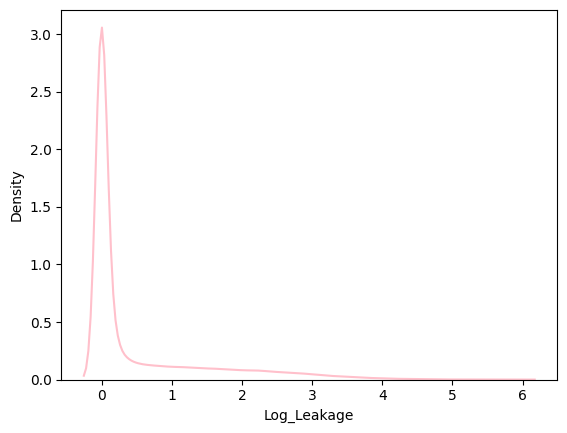

In [5]:
 #Estandarizado por log de leakage
filtro_failure = df['Failure_today'] == 'Yes'
epsilon = 1
df['Log_Leakage'] = np.log(df['Leakage'] + epsilon)
leak_failure = pd.DataFrame(df['Log_Leakage'][filtro_failure])


sns.kdeplot(data=df, x='Log_Leakage', color='pink')

análisis exploratorio de datos especificamente de la variable de filtraciones. Con método logarítmico y método comùn

<Axes: xlabel='Normal_Leakage', ylabel='Density'>

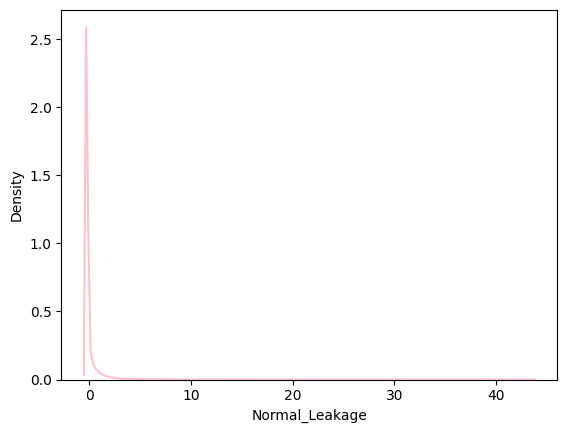

In [6]:
#Estandarizado comun de leakage
media = (df['Leakage']+epsilon).mean()
varianza = (df['Leakage']+epsilon).var()

df['Normal_Leakage'] = (df['Leakage']+epsilon - media)/np.sqrt(varianza)

sns.kdeplot(data=df, x='Normal_Leakage', color='pink')

El método común estandariza Leakage para que tenga media 0 y desviación estándar 1. 
El método logarìtmico aplica una transformación logarítmica para reducir la asimetría.
En conclusión ninguno de los dos métodos es mejor que el otro, ya que ninguno logró estandarizar correctamente la variable de las filtraciones


In [10]:
#categorizar direcciones del viento
df['Is_P1Dir_North'] = df['Parameter1_Dir'].map({'NNW':1, 'N':1,'NNE':1,'NE':1,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

#categorizar direcciones del viento
df['Is_P1Dir_West'] = df['Parameter1_Dir'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':1,'W':1, 'WNW':1,'NW':1})

#categorizar direcciones del viento
df['Is_P1Dir_South'] = df['Parameter1_Dir'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':1,'S':1,'SSW':1,'SW':1,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P1Dir_East'] = df['Parameter1_Dir'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':1,'E':1,'ESE':1,'SE':1,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

#Cargorizar direcciones del parametro 2 de 9am
df['Is_P29am_North'] = df['Parameter2_9am'].map({'NNW':1, 'N':1,'NNE':1,'NE':1,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P29am_West'] = df['Parameter2_9am'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':1,'W':1, 'WNW':1,'NW':1})

df['Is_P29am_South'] = df['Parameter2_9am'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':1,'S':1,'SSW':1,'SW':1,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P29am_East'] = df['Parameter2_9am'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':1,'E':1,'ESE':1,'SE':1,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

#Cargorizar direcciones del parametro 2 de 3pm
df['Is_P23pm_North'] = df['Parameter2_3pm'].map({'NNW':1, 'N':1,'NNE':1,'NE':1,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P23pm_West'] = df['Parameter2_3pm'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':1,'W':1, 'WNW':1,'NW':1})

df['Is_P23pm_South'] = df['Parameter2_3pm'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':0,'E':0,'ESE':0,'SE':0,
                                                'SSE':1,'S':1,'SSW':1,'SW':1,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

df['Is_P23pm_East'] = df['Parameter2_3pm'].map({'NNW':0, 'N':0,'NNE':0,'NE':0,
                                                'ENE':1,'E':1,'ESE':1,'SE':1,
                                                'SSE':0,'S':0,'SSW':0,'SW':0,
                                                'WSW':0,'W':0, 'WNW':0,'NW':0})

In [11]:
#Categorizar meses en estaciones
print(df['Month'].unique())
df['Is_Summer'] = df['Month'].map({ 12:0, 1:0, 2:0,
                                   3:0, 4:0, 5:0,
                                   6:1, 7:1, 8:1,
                                   9:0, 10:0, 11:0})

df['Is_Winter'] = df['Month'].map({12:1, 1:1, 2:1,
                                   3:0, 4:0, 5:0,
                                   6:0, 7:0, 8:0,
                                   9:0, 10:0, 11:0})

df['Is_Fall'] = df['Month'].map({12:0, 1:0, 2:0,
                                   3:0, 4:0, 5:0,
                                   6:0, 7:0, 8:0,
                                   9:1, 10:1, 11:1})

df['Is_Spring'] = df['Month'].map({12:0, 1:0, 2:0,
                                   3:1, 4:1, 5:1,
                                   6:0, 7:0, 8:0,
                                   9:0, 10:0, 11:0})


[12  1  2  3  4  5  6  7  8  9 10 11]


<Axes: >

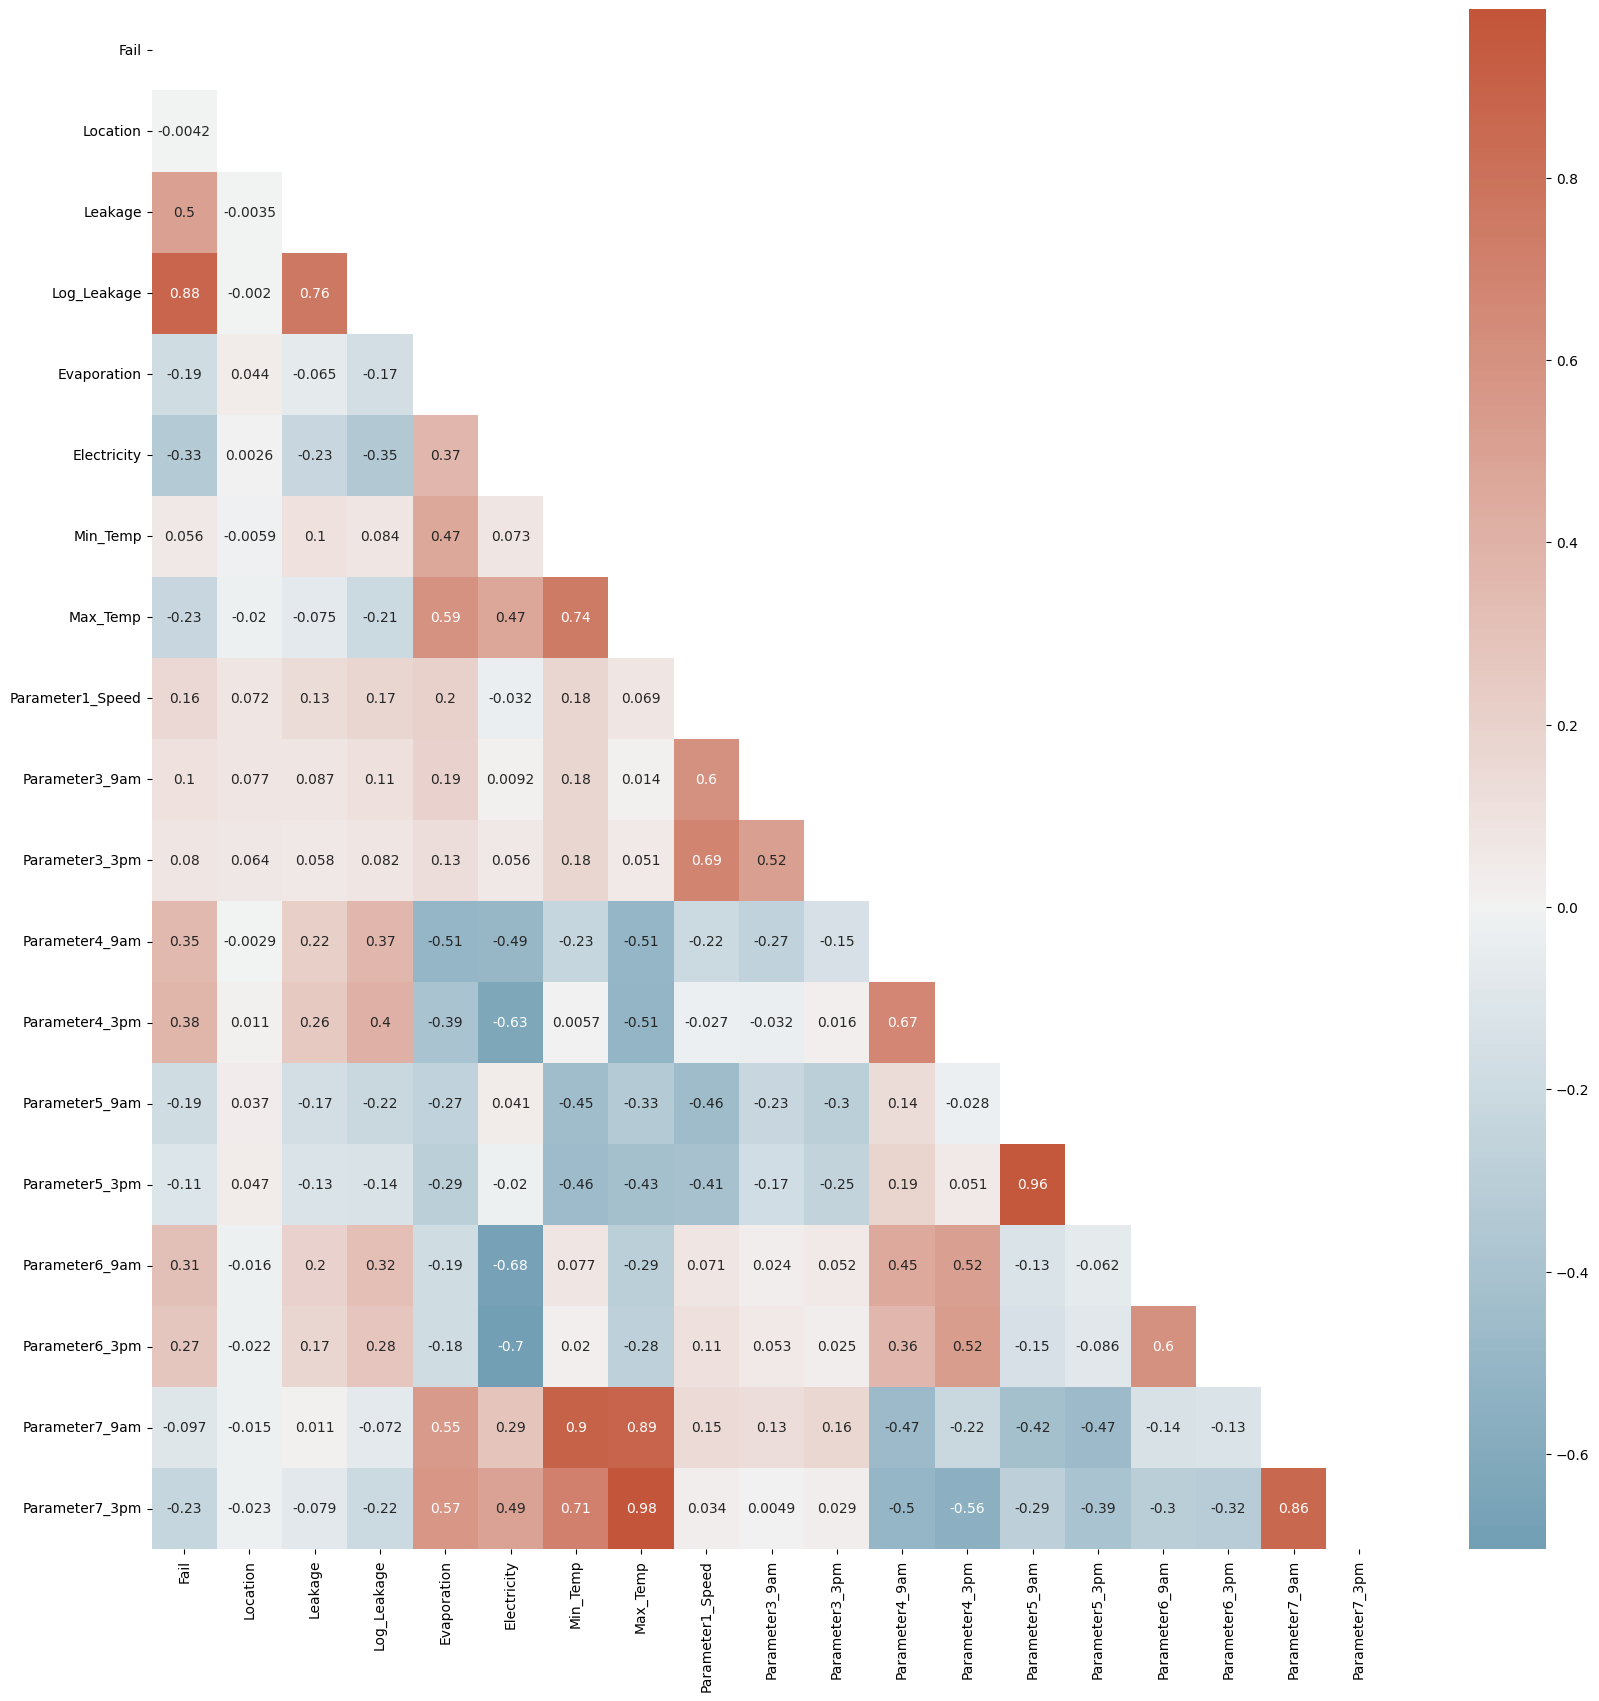

In [12]:
#Elimina las filas donde la columna 'Failure_today' está vacía (NaN).
df = df[df['Failure_today'].notna()]
df['Fail'] = df['Failure_today'].apply(lambda x: 1 if x == 'Yes' else 0)


DF = df[['Fail','Location','Leakage','Log_Leakage', 'Evaporation', 'Electricity','Min_Temp', 'Max_Temp','Parameter1_Speed',
         'Parameter3_9am','Parameter3_3pm','Parameter4_9am','Parameter4_3pm','Parameter5_9am','Parameter5_3pm',
         'Parameter6_9am','Parameter6_3pm','Parameter7_9am','Parameter7_3pm']]
corr = DF.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, center=0,mask=mask, )

#Genera un heatmap (mapa de calor) de correlaciones:

#annot=True: muestra los valores numéricos en cada celda.

#cmap=cmap: paleta de colores divergente.

#center=0: el punto medio de los colores es la correlación cero.

#mask=mask: oculta la parte superior.

La variable Leakage tiene una correlación moderada con Fail (0.5), lo que sugiere que mayores fugas están asociadas con una mayor probabilidad de falla.

Log_Leakage también está muy correlacionada con Leakage (0.88), lo que era esperable ya que es una transformación logarítmica.

Electricity tiene una correlación negativa baja con Fail (-0.33), lo cual podría implicar que cuando el consumo eléctrico baja, aumentan las fallas, aunque la relación no es fuerte.

Las demás variables tienen una correlación muy baja con Fail, por lo que no muestran una relación lineal significativa directa.
Hay variables muy correlacionadas entre sí, lo que puede ser un problema en modelos estadísticos como regresión:

Min_Temp y Max_Temp: 0.74

Parameter6_9am y Parameter6_3pm: 0.96

Parameter7_9am y Parameter7_3pm: 0.86

Parameter3_9am y Parameter3_3pm: 0.69
Evaporation tiene una correlación negativa baja con varias variables, como Max_Temp (-0.17), y su relación con Fail es también baja (-0.19).

Parameter4_9am muestra una correlación negativa moderada con Max_Temp (-0.51), lo que podría indicar sensibilidad a la temperatura en ese parámetro específico.


 Ejecute un modelo de probabilidad lineal (*MCO*) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [13]:
#Regresion excluyendo variables de alta correlacion
#Elimina muchas variables irrelevantes o altamente correlacionadas, incluyendo:
#Variables temporales (Date, Year, Month, Is_Winter).
#Variables categóricas ya codificadas como dummies (Is_P1Dir_West, etc.).
#Variables redundantes con alta correlación, como:
#Evaporation, Electricity (relación baja con falla).
#Leakage, Log_Leakage (muy correlacionadas entre sí).
#Parameter5_3pm, Parameter6_*, Parameter7_* (todas con alta correlación).

#Esto ayuda a evitar multicolinealidad y mejorar la interpretación del modelo.

funcion = df.drop(['Date','Evaporation','Electricity', 
                   'Parameter1_Dir','Parameter2_9am','Parameter2_3pm', 'Is_P1Dir_West', 'Is_P1Dir_South', 'Is_P1Dir_East', 'Is_P1Dir_North',
                   'Is_P29am_North', 'Is_P29am_West', 'Is_P29am_South', 'Is_P29am_East',
                   'Is_P23pm_North', 'Is_P23pm_West', 'Is_P23pm_South', 'Is_P23pm_East',
                   'Failure_today', 'Year', 'Month', 'Is_Winter',
                    'Parameter5_3pm', 'Parameter6_9am','Parameter6_3pm','Parameter7_9am','Parameter7_3pm', 'Normal_Leakage','Leakage','Log_Leakage'], axis=1)
funcion.dropna(inplace=True)

y=funcion['Fail']
X=funcion.drop(['Fail'], axis=1)
X=sm.add_constant(X)
print(funcion.describe())

            Location       Min_Temp       Max_Temp  Parameter1_Speed  \
count  119626.000000  119626.000000  119626.000000     119626.000000   
mean       24.854154      12.386895      23.485793         40.108488   
std        14.537657       6.367256       6.986432         13.480284   
min         1.000000      -8.200000       2.600000          6.000000   
25%        12.000000       7.700000      18.100000         31.000000   
50%        23.000000      12.100000      22.900000         39.000000   
75%        38.000000      17.000000      28.500000         48.000000   
max        49.000000      33.900000      48.100000        135.000000   

       Parameter3_9am  Parameter3_3pm  Parameter4_9am  Parameter4_3pm  \
count   119626.000000   119626.000000   119626.000000   119626.000000   
mean        14.364386       19.082959       68.290806       50.868156   
std          8.796568        8.676046       19.130459       20.692306   
min          0.000000        0.000000        0.000000      

Se observaron 119.626 registros sin valores faltantes para las variables seleccionadas. Variables como Parameter1_Speed y Parameter3_* presentan una distribución amplia, lo cual puede indicar condiciones operativas diversas. Las variables estacionales (Is_Summer, Is_Fall, etc.) están balanceadas, representando todas las estaciones del año. Esta diversidad aporta riqueza al análisis de regresión, permitiendo evaluar el impacto de múltiples factores sobre las fallas.

In [ ]:
model = sm.OLS(y, X)  # Crea el modelo de regresión lineal
results = model.fit(cov_type='HC0') # Ajusta el modelo usando errores robustos (White/HC0)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   Fail   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     3602.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:09:00   Log-Likelihood:                -46373.
No. Observations:              119626   AIC:                         9.277e+04
Df Residuals:                  119613   BIC:                         9.290e+04
Df Model:                          12                                         
Covariance Type:                  HC0                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.5980      0.207  

R-squared: 0.262
→ El modelo explica el 26.2% de la variabilidad de las fallas. Aunque no es muy alto, en contextos industriales y con datos complejos, este valor puede ser aceptable.

F-statistic: 3602, con p-valor = 0.00
→ El modelo en conjunto es estadísticamente significativo.

🔹 Variables significativas (p < 0.05):

Variable	Coeficiente	Sentido	Interpretación
Min_Temp	+0.0191	Positivo	A mayor temperatura mínima, mayor probabilidad de falla.
Max_Temp	-0.0203	Negativo	A mayor temperatura máxima, menor probabilidad de falla.
Parameter1_Speed	+0.0045	Positivo	A más velocidad del parámetro 1, más probabilidad de falla.
Parameter3_9am	+0.0028	Positivo	Más valor a las 9am del parámetro 3, más fallas.
Parameter3_3pm	-0.0043	Negativo	Más valor a las 3pm del parámetro 3, menos fallas.
Parameter4_9am	+0.0068	Positivo	Aumento de este parámetro a las 9am incrementa fallas.
Parameter5_9am	-0.0096	Negativo	A mayor valor, disminuyen las fallas.
Location	-0.0005	Negativo	Aunque pequeño, sugiere que algunas ubicaciones presentan menos fallas.
Is_Summer	+0.0073	Positivo	En verano, las fallas son ligeramente más frecuentes.

❌ Variables no significativas:
Parameter4_3pm → p = 0.863
→ Este parámetro no tiene un efecto estadísticamente significativo en la probabilidad de falla.

✅ Conclusiones
El modelo de regresión lineal explica el 26.2% de la variabilidad en las fallas, lo cual indica que hay otros factores no considerados que podrían influir en el resultado.

La temperatura mínima está positivamente asociada con las fallas, mientras que la temperatura máxima tiene un efecto protector (negativo).

Parámetros operacionales medidos en la mañana (como Parameter3_9am y Parameter4_9am) muestran una fuerte relación con el aumento de fallas, lo cual podría indicar que ciertas condiciones tempranas en el día afectan negativamente.

En verano se observan más fallas, aunque el efecto es leve.

La variable Location influye negativamente en las fallas, posiblemente indicando que algunas ubicaciones son más estables o tienen mejores condiciones de operación.


Ejecute un modelo *probit* para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [14]:
model = sm.Probit(y, X)
probit = model.fit()
print(probit.summary())

mfx = probit.get_margeff()
print(mfx.summary())
# ¿Cuánto cambia la probabilidad de falla cuando una variable independiente aumenta en una unidad, manteniendo las otras constantes?

Optimization terminated successfully.
         Current function value: 0.369234
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:                   Fail   No. Observations:               119626
Model:                         Probit   Df Residuals:                   119613
Method:                           MLE   Df Model:                           12
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3011
Time:                        22:26:58   Log-Likelihood:                -44170.
converged:                       True   LL-Null:                       -63203.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               30.0079      0.843     35.594      0.000      28.356      31.660
Location   

Interpretación del Probit Model
Este modelo estima la probabilidad de que ocurra una falla (Fail = 1), dadas ciertas variables climáticas y de ubicación.

Pseudo R² = 0.3011: Esto indica que el modelo explica aproximadamente el 30.1% de la variabilidad en la probabilidad de falla. Es un buen valor para un modelo con datos binarios, especialmente con muchas observaciones.

Log-Likelihood y LLR p-value = 0.000: Esto indica que el modelo en conjunto es altamente significativo.




Ejecute un modelo *logit*  para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [15]:
model = sm.Logit(y, X)
logit = model.fit()
print(logit.summary())

mfx = logit.get_margeff()
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.368744
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   Fail   No. Observations:               119626
Model:                          Logit   Df Residuals:                   119613
Method:                           MLE   Df Model:                           12
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.3021
Time:                        22:27:06   Log-Likelihood:                -44111.
converged:                       True   LL-Null:                       -63203.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               50.7732      1.480     34.310      0.000      47.873      53.674
Location   

🧠 CONCLUSIONES
Tanto el modelo Logit como el Probit se ajustan mejor que OLS para modelar una variable binaria como Fail.
El Logit tuvo una Pseudo R² apenas superior (0.302 vs 0.301), pero ambos son prácticamente equivalentes en rendimiento.
El modelo OLS, aunque útil para exploración inicial, no es adecuado para este tipo de problema, ya que no limita las predicciones entre 0 y 1.

Coeficientes:

En OLS, los coeficientes representan cambios absolutos en la probabilidad.
En Logit y Probit, los coeficientes representan cambios en los log-odds (logit) o en la función normal inversa (probit).
Para ambos, es mejor interpretar los efectos marginales (que mostraste con .get_margeff()).
Variables como Min_Temp, Max_Temp, Parameter4_9am, y Parameter1_Speed son altamente significativas y con efectos consistentes entre modelos.

Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

Modelo 2: Probit
Pseudo R² = 0.3011 → Buen nivel de ajuste para un modelo de clasificación.
Todos los coeficientes principales son estadísticamente significativos (p < 0.05).

La mayoría de los signos de los coeficientes tienen sentido económico o físico (por ejemplo, aumento de Min_Temp aumenta la probabilidad de falla, lo que podría asociarse a condiciones extremas).
La función de enlace Probit utiliza la distribución normal acumulada, lo que suaviza el efecto de los predictores.

Modelo 3: Logit
Pseudo R² = 0.3021 → Prácticamente igual al modelo Probit, pero ligeramente superior.
Signos y significancia de las variables son casi idénticos al modelo Probit, lo que sugiere consistencia.
La diferencia principal es el uso de una función logística como función de enlace, que es más interpretada en términos de odds.

Modelo 4: OLS
R² = 0.262 → Mucho menor ajuste comparado con los modelos Probit y Logit.
El modelo asume que la variable dependiente es continua, lo cual no es el caso aquí (la variable Fail es binaria).
Aunque los coeficientes pueden ser significativos, las predicciones pueden quedar fuera del rango [0, 1], lo que es problemático para clasificación.
OLS se puede usar exploratoriamente, pero no es apropiado para inferencia en variables binarias.

¿Por qué existen diferencias entre los modelos?
Naturaleza del modelo: OLS asume una relación lineal y no considera que la variable dependiente sea binaria.
Logit y Probit sí respetan esa naturaleza al modelar la probabilidad de ocurrencia de un evento.

Función de enlace: Logit usa la función logística, Probit usa la función normal acumulada.
Aunque dan resultados similares, difieren en la forma en que suavizan los cambios de probabilidad.

Interpretación de coeficientes:
En OLS: cambios absolutos en la variable dependiente.
En Logit/Probit: cambios en los log-odds (logit) o z-scores normalizados (probit). Se requiere calcular efectos marginales para interpretarlos fácilmente.

¿Cuál modelo es el más adecuado?
El modelo Logit sería el más adecuado, ya que iene el mejor ajuste (Pseudo R² más alto).
Converge bien, y tiene resultados robustos y estadísticamente significativos.
Sus efectos marginales son más fáciles de interpretar en contextos prácticos.
Probit también sería aceptable, especialmente si se justifica teóricamente el uso de la normalidad (por ejemplo, decisiones latentes). OLS, en cambio, no debería usarse como modelo final por la naturaleza de la variable dependiente.

¿Qué variables resultaron ser robustas?
Min_Temp: Aumenta riesgo de falla.
Max_Temp: Disminuye riesgo (quizás relacionado con clima estable).
Parameter1_Speed: A mayor velocidad, mayor probabilidad de falla.
Parameter4_9am: Fuerte impacto positivo.
Parameter5_9am: Relación negativa consistente.
Parameter3_9am/3pm: Cambios sutiles pero robustos.
Location: Efecto leve pero significativo.


Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 

In [16]:
df_mes = df.drop(['Date','Failure_today',
                   'Parameter1_Dir','Parameter2_9am','Parameter2_3pm', 'Is_P1Dir_West', 'Is_P1Dir_South', 'Is_P1Dir_East', 'Is_P1Dir_North',
                   'Is_P29am_North', 'Is_P29am_West', 'Is_P29am_South', 'Is_P29am_East',
                   'Is_P23pm_North', 'Is_P23pm_West', 'Is_P23pm_South', 'Is_P23pm_East',
                   'Is_Winter','Is_Summer','Is_Fall','Is_Spring'
                    ], axis=1)



# Creamos un diccionario con funciones agregadas
agg_dict = {col: 'mean' for col in df_mes.columns if col not in ['Year', 'Month', 'Location', 'Fail']}
agg_dict['Fail'] = 'sum'

# Aplicamos el groupby con agregación personalizada
df_mes = df_mes.groupby(['Year', 'Month', 'Location']).agg(agg_dict).reset_index()


#df_mensual = df_mensual.groupby(['Year', 'Month','Location']).mean()
df_mes['Has_Failed'] = df_mes['Fail'].apply(lambda x: 1 if x != 0.0 else 0)

# Imputar NaNs con la media de cada columna para limpiar que y que no hayan datos faltantes, en vez de elimminarlos mejor usamos la media 
# Para que no haya un impacto en las otras filas y en los otros
for col in df_mes.columns:
    if df_mes[col].isna().sum() > 0:
        df_mes[col].fillna(df_mes[col].mean(), inplace=True)
df_mes

,Year,Month,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,Parameter1_Speed,Parameter3_9am,...,Parameter5_9am,Parameter5_3pm,Parameter6_9am,Parameter6_3pm,Parameter7_9am,Parameter7_3pm,Log_Leakage,Normal_Leakage,Fail,Has_Failed
0,2007,11,10,11.753333,25.053333,3.180000,5.900000,7.880000,41.266667,9.166667,...,1018.550000,1015.450000,4.400000,4.866667,16.750000,23.720000,0.568132,0.098052,7,1
1,2007,12,10,13.312903,25.119355,3.258065,5.819355,8.287097,40.580645,10.032258,...,1015.051613,1012.696774,5.000000,4.903226,17.767742,23.200000,0.804126,0.107274,12,1
2,2008,1,10,15.348387,29.125806,1.412903,7.941935,9.119355,43.064516,9.709677,...,1014.096774,1011.290323,4.225806,4.000000,19.716129,27.348387,0.349507,-0.110697,5,1
3,2008,2,10,12.700000,24.572414,2.227586,5.862069,8.234483,40.896552,9.777778,...,1013.479310,1010.717241,4.551724,4.724138,16.265517,23.210345,0.616497,-0.014458,9,1
4,2008,2,38,18.503448,24.751724,8.910345,5.442857,5.662069,40.010661,12.931034,...,1013.513793,1012.106897,5.965517,5.586207,20.903448,23.203448,1.313197,0.774984,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4762,2017,6,45,4.424000,14.744000,0.648000,1.344000,4.632000,24.040000,4.960000,...,1028.816000,1026.476000,4.960000,5.400000,6.736000,13.696000,0.262493,-0.201056,3,1
4763,2017,6,46,10.100000,18.356000,9.256000,5.623591,7.631128,34.120000,16.440000,...,1025.720000,1023.492000,6.250000,6.812500,13.168000,17.304000,1.333564,0.815816,13,1
4764,2017,6,47,8.736000,18.616000,3.760000,5.623591,7.631128,34.000000,9.520000,...,1024.156000,1022.168000,4.577925,4.574191,12.948000,17.360000,0.808710,0.166568,9,1
4765,2017,6,48,11.788889,17.816667,4.177778,5.623591,7.631128,37.166667,14.666667,...,1026.405556,1024.283333,7.000000,5.555556,14.922222,16.855556,0.593036,0.215920,4,1


Finalmente aplicamos poisson.

In [17]:
import statsmodels.api as sm

# Definir variables dependiente e independientes
y = df_mes['Fail']
X = df_mes[['Year','Month', 'Location', 'Min_Temp', 'Max_Temp', 'Leakage', 'Evaporation', 'Electricity', 'Parameter1_Speed', 'Parameter3_9am', 'Parameter3_3pm',
            'Parameter4_9am', 'Parameter4_3pm', 'Parameter5_9am', 'Parameter5_3pm', 'Parameter6_9am', 'Parameter6_3pm', 'Parameter7_9am', 'Parameter7_3pm', 'Parameter7_3pm']]  
X = sm.add_constant(X)

# Modelo Poisson
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Fail   No. Observations:                 4767
Model:                            GLM   Df Residuals:                     4747
Model Family:                 Poisson   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10832.
Date:               jue, 24 abr. 2025   Deviance:                       5404.8
Time:                        22:27:19   Pearson chi2:                 4.83e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.8633
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               12.0695      4.961  

Variables no significativas:
Parameter3_9am
Parameter7_3pm
Location
Year

Variables robustas:
Min_Temp (positivo)
Max_Temp (negativo)
Parameter1_Speed (positivo)
Parameter4_9am (positivo)
Parameter5_9am (negativo)
Leakage (positivo)

Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

In [20]:
import statsmodels.api as sm

# Ajuste del modelo Poisson
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Verificar sobredispersión
print("Deviance / DF Residual:", poisson_model.deviance / poisson_model.df_resid)


Deviance / DF Residual: 1.1385778519360172


In [ ]:
import statsmodels.api as sm

# Asume que 'X' es la matriz de variables explicativas y 'y' es la columna Fail
nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()
print(nb_results.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Fail   No. Observations:                 4767
Model:                            GLM   Df Residuals:                     4747
Model Family:        NegativeBinomial   Df Model:                           19
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13366.
Date:               jue, 24 abr. 2025   Deviance:                       1173.8
Time:                        22:29:01   Pearson chi2:                     809.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.2667
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               15.9068     14.097  

In [24]:
#Alpha es la estimacion de de la dispersion de la data

var = df_mes['Fail'].var()
media = df_mes['Fail'].mean()

print("Media:", media)
print("Varianza:", var)

Media: 6.598489616110761
Varianza: 19.592847067821232



Para calcular alpha debe resolver lo siguiente:
$\alpha = \frac{\text{Varianza} - \mu}{\mu^2}$

In [25]:
print("Alpha:", (var-media)/media**2)

Alpha: 0.2984459804519457


Ese valor de α = 0.298 indica que existe sobredispersión en los datos. 

Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado. 


(13, 7)


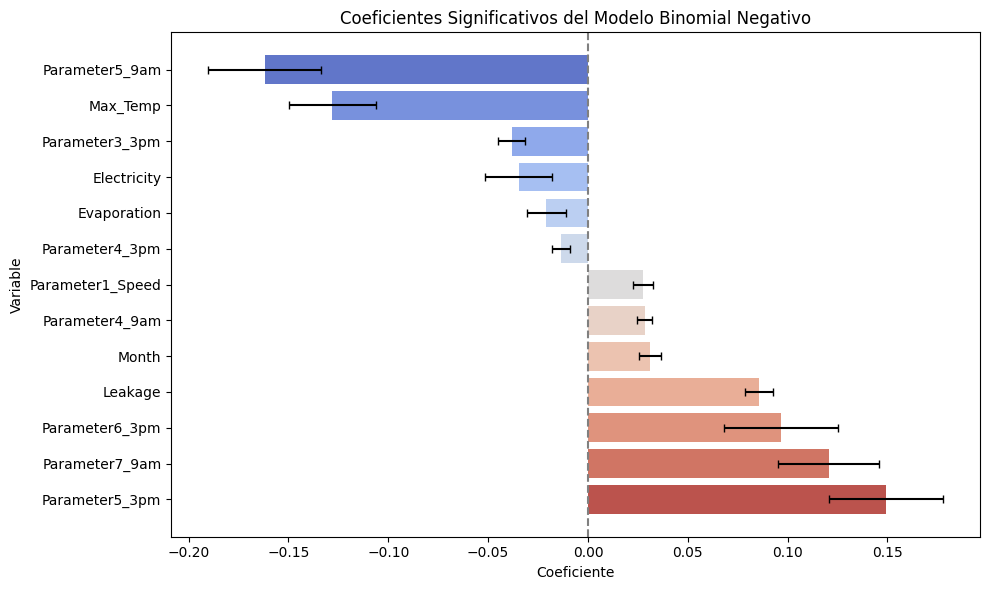

In [ ]:
print(significant_vars.shape)

import matplotlib.pyplot as plt
import seaborn as sns

# Ordenar por coeficiente para mejor visualización
significant_vars = significant_vars.sort_values('Coeficiente')

plt.figure(figsize=(10, 6))

# Barplot sin errorbars
sns.barplot(
    x='Coeficiente',
    y='Variable',
    data=significant_vars,
    palette='coolwarm',
    orient='h'
)

# Añadir barras de error con matplotlib
plt.errorbar(
    x=significant_vars['Coeficiente'],
    y=range(len(significant_vars)),
    xerr=significant_vars['Error Std'],
    fmt='none',
    ecolor='black',
    capsize=3
)

plt.title('Coeficientes Significativos del Modelo Binomial Negativo')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Coeficiente')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


El gráfico de coeficientes significativos del modelo binomial negativo revela que varias variables tienen un impacto estadísticamente significativo sobre la variable dependiente. En particular, se observan efectos tanto positivos como negativos. Entre los más destacados, Parameter5_9am y Max_Temp presentan coeficientes negativos pronunciados, lo que sugiere que un aumento en estas variables se asocia con una disminución en el resultado esperado. Por otro lado, variables como Parameter5_3pm, Parameter7_9am y Parameter6_3pm muestran efectos positivos significativos, indicando que incrementos en estos predictores están relacionados con un aumento en el número esperado de eventos.

Estos resultados aportan evidencia empírica relevante sobre los factores que influyen significativamente en el fenómeno estudiado, y pueden servir como base para futuras decisiones analíticas o intervenciones prácticas.

Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

Los modelos estimados  presentan diferencias notables en la significancia de los coeficientes y en la magnitud de los efectos. Estas diferencias se deben principalmente a cómo cada modelo maneja la dispersión de los datos:

Modelo de Poisson: Asume equidispersión (media = varianza). Este supuesto no se cumple en nuestros datos, lo que afecta la validez de los errores estándar y puede llevar a una identificación errónea de variables significativas.

Modelo Binomial Negativo: Introduce un parámetro de sobre-dispersión que permite que la varianza sea mayor que la media, ajustándose mejor a los datos. Este modelo mostró un mejor ajuste y una identificación más razonable de variables significativas.

Modelo Quasi-Poisson o Poisson con errores robustos: Corrige la dispersión en los errores estándar sin modificar la función de verosimilitud. Es útil para obtener inferencia válida en presencia de sobre-dispersión, pero no mejora el ajuste del modelo como sí lo hace el Binomial Negativo.

Diferencias en los resultados:

Las diferencias en los coeficientes significativos se deben a la sensibilidad de cada modelo frente a la sobre-dispersión. En el modelo de Poisson algunos efectos pueden haber aparecido como significativos por errores estándar subestimados. El modelo Binomial Negativo ajustó mejor los datos, reduciendo falsos positivos y mostrando una imagen más fiable de las relaciones entre variables. El modelo Quasi-Poisson ofreció una solución intermedia, con coeficientes similares al de Poisson, pero errores estándar más realistas.

Modelo más adecuado:

En mi opinión, el modelo Binomial Negativo es el más adecuado. Este modelo captura adecuadamente la estructura de dispersión de los datos, proporciona estimaciones consistentes y permite una mejor identificación de las variables relevantes, todo lo cual es crucial para interpretar correctamente los determinantes del fenómeno observado.

Variables robustas a la especificación:

Al comparar los tres modelos, se observa que algunas variables como Max_Temp, Electricity, y Parameter5_3pm aparecen como significativas de manera consistente. Esto sugiere que estos predictores son robustos a la especificación del modelo, es decir, su relevancia no depende del tipo de modelo utilizado, lo que fortalece la confianza en su efecto sobre la variable dependiente.